**CHEST XRAY CLASSIFIER (NORMAL And PNEUMONIA)**

Pneumonia is an infection that causes inflammation of the air sacs (alveoli) in one or both lungs. The alveoli may fill with fluid or pus, disrupting the oxygen exchange process. We use CNN Deep Learning tensor flow keras and application VGG19

**Set Up Libbrary and Package**

In [9]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import re
import pandas as pd
from keras.utils import image_dataset_from_directory
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten,Dropout, GlobalAveragePooling2D
from keras.layers import Conv2D,MaxPooling2D
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense, BatchNormalization
from keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import AUC, Precision
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications import VGG19
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.regularizers import l2
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay

**Load Data**

In [2]:
data_path = r"D:\MACHINE LEARNING\KNEE\Osteoporosis Knee X-ray\archive\chest_xray\x-ray"
categories = os.listdir(data_path)

# List to save information image
image_data = []
labels = []

# loops through each category (folder)
for category in categories:
    folder_path = os.path.join(data_path, category)
    
    # Sort files naturally by number
    image_files = sorted(os.listdir(folder_path), key=lambda x: int(re.search(r'\d+', x).group()))
    
    for img_name in image_files:
        img_path = os.path.join(folder_path, img_name)
        
        # Read image use OpenCV
        img = cv2.imread(img_path)
        
        if img is not None:
            # Resize image to size consistent (example, 64x64)
            img_resized = cv2.resize(img, (224, 224))
            
            # convert to array 1D (flatten)
            img_flattened = img_resized.flatten()
            
            # Add image and label data to the list
            image_data.append(img_flattened)
            labels.append(category)  # Label dari nama folder
        else:
            print(f"Could not read image: {img_path}")

# convert list to DataFrame
df = pd.DataFrame(image_data)
df['Label'] = labels  # add column label

# view DataFrame
print(df.head())

    0   1   2   3   4   5   6   7   8   9  ...  150519  150520  150521  \
0  24  24  24  20  20  20  19  19  19  17  ...     108     108     108   
1  14  14  14  24  24  24  25  25  25  31  ...       0       0       0   
2   0   0   0   0   0   0   0   0   0   8  ...       0       0       0   
3  40  40  40  46  46  46  47  47  47  55  ...      11      11      11   
4  77  77  77  77  77  77  62  62  62  57  ...       0       0       0   

   150522  150523  150524  150525  150526  150527   Label  
0     113     113     113     110     110     110  Normal  
1       0       0       0       0       0       0  Normal  
2       0       0       0       3       3       3  Normal  
3      11      11      11      11      11      11  Normal  
4       0       0       0       0       0       0  Normal  

[5 rows x 150529 columns]


**Data Visualization**

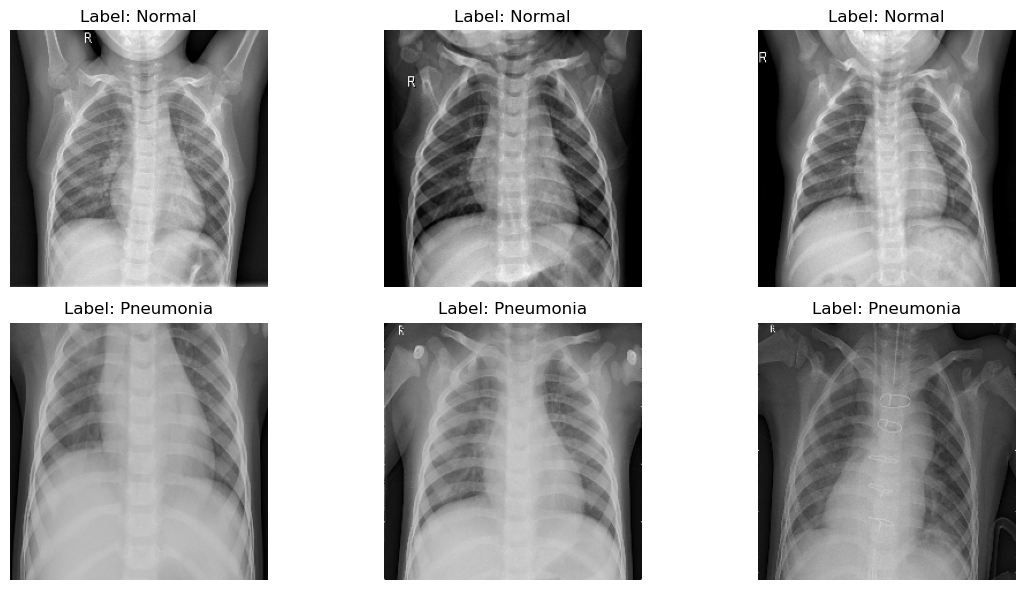

In [35]:
normal_images = df[df['Label'] == 0].iloc[:3, :-1].values  # Take 3 images labeled 0 (Normal)
pneumonia_images = df[df['Label'] == 1].iloc[:3, :-1].values  # Take 3 images with label 1 (Pneumonia)

# Validate data availability
if len(normal_images) == 0 or len(pneumonia_images) == 0:
    print("Salah satu label tidak memiliki cukup data untuk ditampilkan.")
else:
    # Combine both categories
    images_to_display = np.vstack((normal_images, pneumonia_images))
    labels_to_display = ['Normal'] * 3 + ['Pneumonia'] * 3

    # Show picture
    plt.figure(figsize=(12, 6))
    for i in range(6):
        img_array = images_to_display[i].reshape(224, 224, 3)  # Sesuaikan dengan ukuran gambar
        plt.subplot(2, 3, i + 1)
        plt.imshow(img_array.astype(np.uint8))  # Pastikan dalam format uint8
        plt.title(f'Label: {labels_to_display[i]}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

Insight: from image above we see a normal label most dark

**Exploratory Data Analysis**

In [3]:
df['Label'].nunique()

2

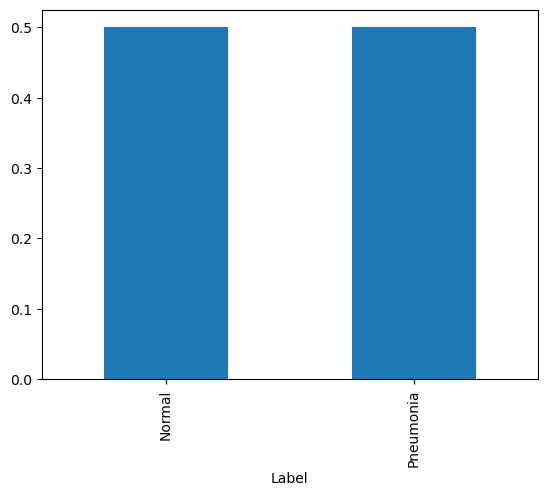

In [4]:
df['Label'].value_counts(normalize=True).plot(kind='bar');

Insight: Proportion label has balance

**Data Preprosesing and Train test Split**

In [5]:
df_copy = df

In [6]:
df_copy['Label'] = df_copy['Label'].apply(lambda x: 1 if x == 'Pneumonia' else 0)

X = df_copy.drop('Label', axis=1).values  # COnversion to array NumPy
y = df_copy['Label'].values               # Label: column 'Label'

# Convert labels to categorical format (single-heat coding)
y = to_categorical(y)

# Reshape X back into a 64x64x3 image (for example, image size 64x64, 3 color channels)
X = X.reshape(-1, 224, 224, 3).astype('float32')

# Normalize the image so that the pixel values are in the range [0, 1]
X = X / 255.0

# Split the dataset into train (80%) and test (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
df_copy['Label'].nunique()

2

Insight: class target is two, for test data we use 20% from all data

**Modeling**

In [11]:
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze VGG19 pre-trained layer
base_model.trainable = False

# Model CNN
model = Sequential([ 
    base_model,
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')  # Output layer for binary classification
])

optimizer = Adam(learning_rate=0.001)

model.compile(
    loss='categorical_crossentropy',  # For Classification biner
    optimizer=optimizer,
    metrics=['accuracy', AUC(name='auc'), Precision(name='precision')]
)

# Callbacks
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.8,patience=10, min_lr=1e-7),
    EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True),
    ModelCheckpoint('best_model_p.h5', monitor='val_accuracy', save_best_only=True)]

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 conv2d (Conv2D)             (None, 7, 7, 64)          294976    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 3, 3, 64)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 3, 3, 128)         73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 1, 1, 128)        0         
 2D)                                                             
                                                                 
 global_average_pooling2d (G  (None, 128)              0

Insight: We use pre-trained VGG19, because dataset not enough information

In [12]:
history = model.fit(X_train, y_train, 
                    batch_size=8, 
                    validation_data=(X_test, y_test),
                    epochs=100,
                   callbacks=callbacks)

Epoch 1/100
40/40 [==============================] - 114s 3s/step - loss: 0.3227 - accuracy: 0.8406 - auc: 0.9328 - precision: 0.8406 - val_loss: 0.4574 - val_accuracy: 0.8125 - val_auc: 0.9133 - val_precision: 0.8125 - lr: 0.0010
Epoch 2/100
40/40 [==============================] - 108s 3s/step - loss: 0.1320 - accuracy: 0.9438 - auc: 0.9892 - precision: 0.9438 - val_loss: 0.2536 - val_accuracy: 0.9000 - val_auc: 0.9666 - val_precision: 0.9000 - lr: 0.0010
Epoch 3/100
40/40 [==============================] - 109s 3s/step - loss: 0.0766 - accuracy: 0.9719 - auc: 0.9953 - precision: 0.9719 - val_loss: 0.2320 - val_accuracy: 0.9125 - val_auc: 0.9766 - val_precision: 0.9125 - lr: 0.0010
Epoch 4/100
40/40 [==============================] - 107s 3s/step - loss: 0.0477 - accuracy: 0.9812 - auc: 0.9988 - precision: 0.9812 - val_loss: 0.1695 - val_accuracy: 0.9375 - val_auc: 0.9822 - val_precision: 0.9375 - lr: 0.0010
Epoch 5/100
40/40 [==============================] - 107s 3s/step - loss: 0.

Insight: We use epoch 100, but no incrase even decrase for val_accuracy so proses has stop in epoch 14

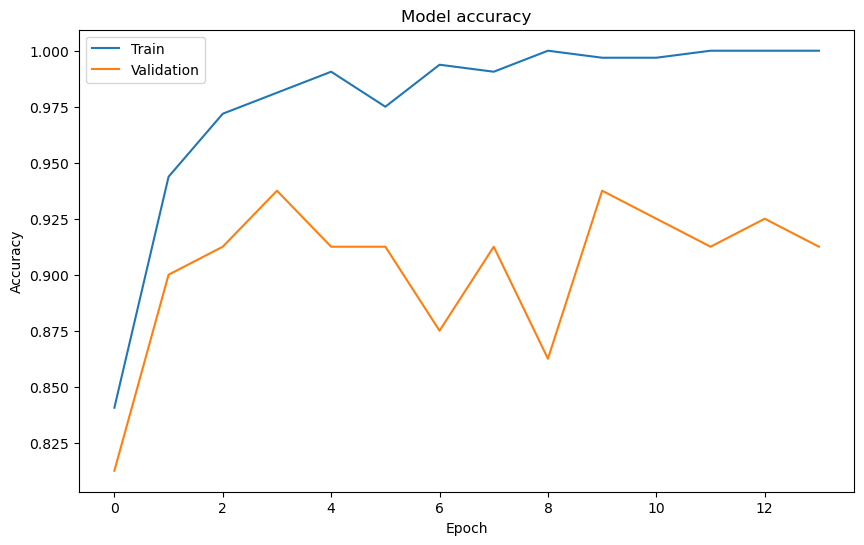

In [38]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

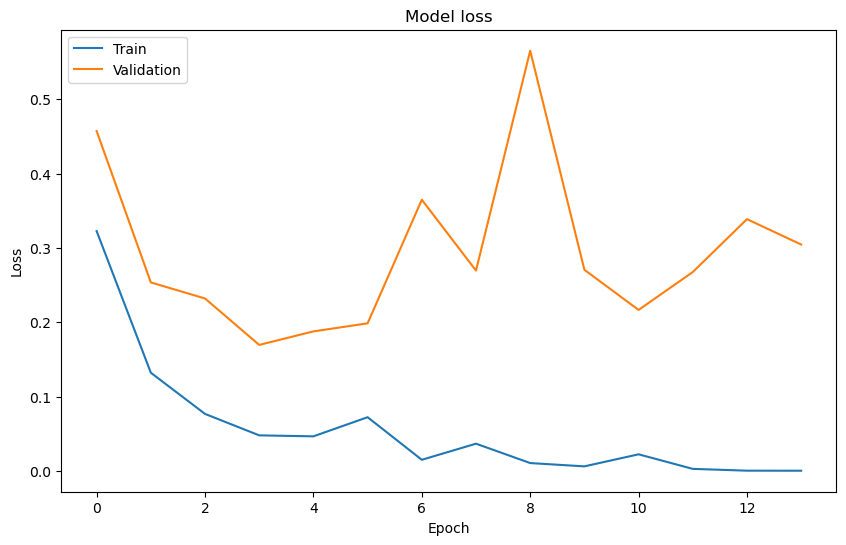

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

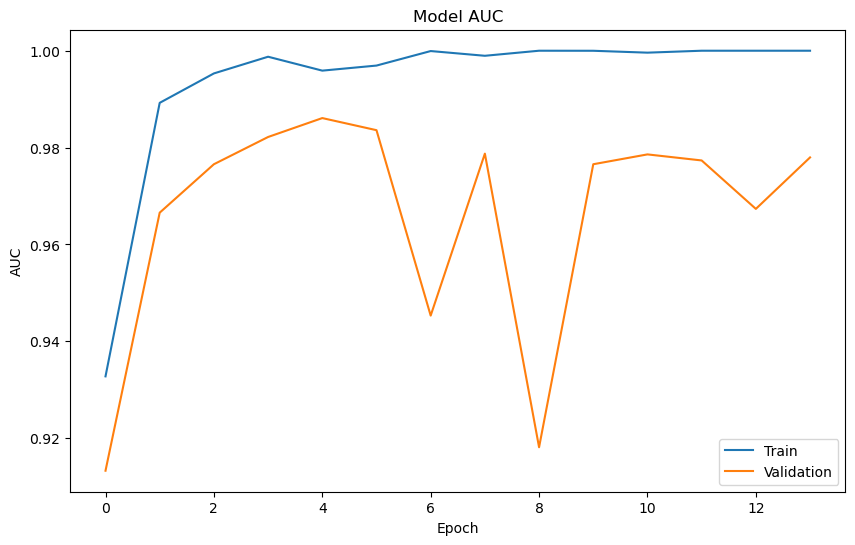

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

In [78]:
model.save('model_pneumonia.h5')
model.save('saved_model_pneumonia')
model.save_weights('model_weights_pneumonia.h5')

INFO:tensorflow:Assets written to: saved_model_pneumonia\assets


INFO:tensorflow:Assets written to: saved_model_pneumonia\assets


**Evaluation**

In [17]:
y_pred_probs = model.predict(X_test)

3/3 [==============================] - 17s 5s/step


In [18]:
y_prob_pos = y_pred_probs[:, 1]

In [19]:
y_true = np.argmax(y_test, axis=1)

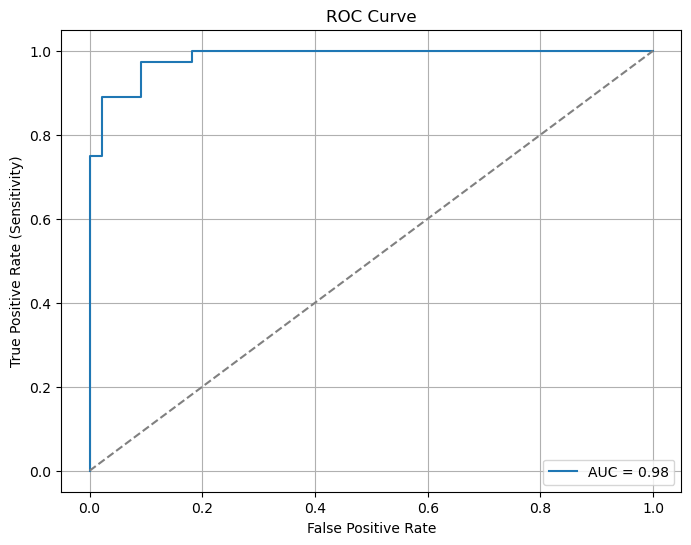

In [20]:
fpr, tpr, thresholds = roc_curve(y_true, y_prob_pos)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_true, y_prob_pos):.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # line diagonal random
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

Insight: From Above model can sparate class AUC 98%

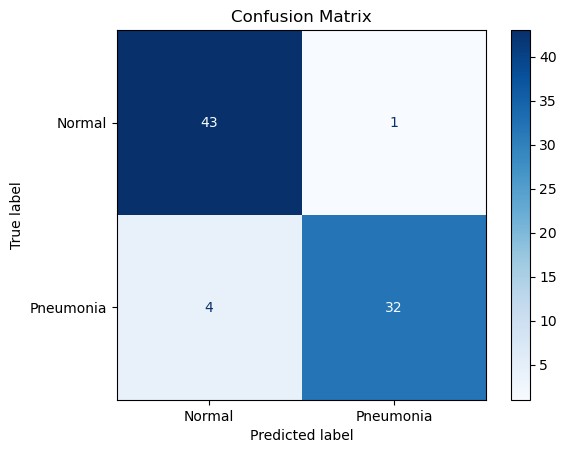

In [39]:
if y_pred_probs.shape[1] > 1:
    y_pred = np.argmax(y_pred_probs, axis=1)  # For multi-class
else:
    y_pred = (y_pred_prob > 0.5).astype(int)  # For binary classification with a default threshold of 0.5

# Make confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Show confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Pneumonia'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


Insight: From above matrix we see tru label normal most high than predict label Pneumonia

**Conclusion**

From build modeling above we can use deployment for predict new data test, with Accuracy model validation until 98%

**Reference**

    1. https://www.kaggle.com/code/madz2000/pneumonia-detection-using-cnn-92-6-accuracy
    2. https://www.analyticsvidhya.com/
    3. https://www.tensorflow.org/guide/keras
    4. https://keras.io/